In [ ]:
u%%capture

!pip install pytorch-lightning
!pip install wandb


from google.colab import drive
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.models as models
import torchmetrics
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import wandb
import cv2
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from PIL import Image
import io
import os
from os import listdir
from os.path import isfile, join

drive.mount('/content/drive')

In [ ]:
class PneumoniaClassifier(pl.LightningModule):


    def __init__(self, learning_rate):
        super().__init__()
        
        import wandb

        from pytorch_lightning.loggers import WandbLogger
        wandb.init()

        google_net = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)

        self.model = google_net
        output_feats = self.model.fc.out_features
        classifier = nn.Sequential(*[nn.Linear(output_feats, 2)])
        self.classifier = classifier
        print(self.model)


        self.learning_rate = learning_rate
        
        self.valid_acc = torchmetrics.Accuracy()
        
        self.test_acc = torchmetrics.Accuracy()
        self.confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=2, average='macro')
        self.val_f1 = torchmetrics.F1Score(num_classes=2, average='macro')
        self.val_auroc = torchmetrics.AUROC(num_classes=2, average='macro')

        self.test_f1 = torchmetrics.F1Score(num_classes=2, average='macro')
        self.test_auroc = torchmetrics.AUROC(num_classes=2, average='macro')

        #self.grad_check = self.model.gradients

    def forward(self, x):

        x = self.model(x)       
        x = torch.squeeze(x)
        x = self.classifier(x)

        return x

    def cross_entropy_loss(self, logits, labels):
        return F.cross_entropy(logits, labels,weight=torch.cuda.FloatTensor([100,1])

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('train_loss', loss)
        self.log("learningrate",self.learning_rate)

        """"
        preds = torch.argmax(logits, -1) #label index

        bz, nc, h, w = self.model.layer

        self.model.conv.register_backward_hook(hook_fn)

        params = list(self.model.parameters())
        class_weight = np.squeeze(params[-1].data.numpy())
        weight_winner = np.squeeze(params[preds].data.numpy())

        activations = logits
        #heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= torch.max(heatmap)
        img = x
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        superimposed_img = heatmap*0.5+img
        heatmap = np.uint8(heatmap)
      
       
        images_to_log_grad = [wandb.Image(heatmap, caption=f"Pred:{pred}, Label:{y}") 
                          for x, pred, y in zip(x[:32], #nr_samples = 32 batchsize
                                                preds[:32], 
                                                y[:32])]

        wandb.log({'images_prediction_gradcam':images_to_log_grad})  
        """
        
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('val_loss', loss)
        self.valid_acc(logits, y)
        self.log('valid_acc', self.valid_acc)

    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('test_loss', loss)
        self.test_acc(logits, y)
        self.log('test_acc', self.test_acc)
        self.confusion_matrix.update(logits, y)
        self.test_f1.update(logits, y)
        self.log('test_f1', self.test_f1)
        self.test_auroc(logits,y)
        self.log('test_auroc', self.test_auroc)

        #self.log("images_testset",show_img)
        preds = torch.argmax(logits, -1)
      # Log the images as wandb Image
        images_to_log = [wandb.Image(x, caption=f"Pred:{pred}, Label:{y}") 
                          for x, pred, y in zip(x[:32], #nr_samples = 32 batchsize
                                                preds[:32], 
                                                y[:32])]

        #val_table = wandb.Table(data=images_to_log)
        #wandb.log({'images_table':val_table})  

        wandb.log({'images_prediction':images_to_log})  
        #        trainer.logger.experiment.log({



    def activations_hook_grad(self, grad):  #hook to extract the gradients
        self.gradient = grad

    def get_grad(self):
        params = self.state_dict()
        for k, v in params.items():
            grads = v.grad
        return grads    
        #return self.gradients  


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=0.01)

        return optimizer

In [ ]:
class PneumoniaClassifier2(pl.LightningModule):


    def __init__(self, learning_rate):
        super().__init__()
      
        wandb.init()

        resnet = models.resnet50(pretrained = True)
        self.model = resnet

        output_feats = self.model.fc.out_features
        classifier = nn.Sequential(*[nn.Linear(output_feats, 2)])
        #classifier = nn.Sequential(*[nn.Linear(output_feats, 1)])
        self.classifier = classifier


        self.learning_rate = learning_rate
        
        self.valid_acc = torchmetrics.Accuracy()
        
        self.test_acc = torchmetrics.Accuracy()
        self.confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=2, average='macro')
        self.val_f1 = torchmetrics.F1Score(num_classes=2, average='macro')
        self.val_auroc = torchmetrics.AUROC(num_classes=2, average='macro')

        self.test_f1 = torchmetrics.F1Score(num_classes=2, average='macro')
        self.test_auroc = torchmetrics.AUROC(num_classes=2, average='macro')

        #self.grad_check = self.model.gradients

    def forward(self, x):

        x = self.model(x)       
        x = torch.squeeze(x)
        x = self.classifier(x)

        return x

    def cross_entropy_loss(self, logits, labels):
      def cross_entropy_loss(self, logits, labels):
        return F.cross_entropy(logits, labels, weight=torch.cuda.FloatTensor([100,1]))
        #return F.cross_entropy(logits, labels, weight=torch.cuda.FloatTensor([5,1]), label_smoothing=0.1)
        #return F.hinge_embedding_loss(logits, labels.float())
        #return F.binary_cross_entropy_with_logits(logits, labels.float())

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('train_loss', loss)
        self.log("learningrate",self.learning_rate)
        
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('val_loss', loss)
        self.valid_acc(logits, y)
        self.log('valid_acc', self.valid_acc)

    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('test_loss', loss)
        self.test_acc(logits, y)
        self.log('test_acc', self.test_acc)
        self.confusion_matrix.update(logits, y)
        self.test_f1.update(logits, y)
        self.log('test_f1', self.test_f1)
        self.test_auroc(logits,y)
        self.log('test_auroc', self.test_auroc)

        #self.log("images_testset",show_img)
        preds = torch.argmax(logits, -1)
      # Log the images as wandb Image
        images_to_log = [wandb.Image(x, caption=f"Pred:{pred}, Label:{y}") 
                          for x, pred, y in zip(x[:32], #nr_samples = 32 batchsize
                                                preds[:32], 
                                                y[:32])]

        #val_table = wandb.Table(data=images_to_log)
        #wandb.log({'images_table':val_table})  

        wandb.log({'images_prediction_model2':images_to_log})  
        #        trainer.logger.experiment.log({



    def activations_hook_grad(self, grad):  #hook to extract the gradients
        self.gradient = grad

    def get_grad(self):
        params = self.state_dict()
        for k, v in params.items():
            grads = v.grad
        return grads    
        #return self.gradients  


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, weight_decay=0.01)

        return optimizer

In [ ]:
class PneumoniaClassifier3(pl.LightningModule):


    def __init__(self, learning_rate):
        super().__init__()
        
        wandb.init()

        densenet = torchvision.models.densenet121(pretrained=True) 
        self.model = densenet

        output_feats = self.model.classifier.out_features
        classifier = nn.Sequential(*[nn.Linear(output_feats, 2)])
        self.classifier = classifier


        self.learning_rate = learning_rate
        
        self.valid_acc = torchmetrics.Accuracy()
        
        self.test_acc = torchmetrics.Accuracy()
        self.confusion_matrix = torchmetrics.ConfusionMatrix(num_classes=2, average='macro')
        self.val_f1 = torchmetrics.F1Score(num_classes=2, average='macro')
        self.val_auroc = torchmetrics.AUROC(num_classes=2, average='macro')

        self.test_f1 = torchmetrics.F1Score(num_classes=2, average='macro')
        self.test_auroc = torchmetrics.AUROC(num_classes=2, average='macro')

        #self.grad_check = self.model.gradients

    def forward(self, x):

        x = self.model(x)       
        x = torch.squeeze(x)
        x = self.classifier(x)

        return x

    def cross_entropy_loss(self, logits, labels):
        return F.cross_entropy(logits, labels,weight=torch.cuda.FloatTensor([100,1]))

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('train_loss', loss)
        self.log("learningrate",self.learning_rate)
        
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('val_loss', loss)
        self.valid_acc(logits, y)
        self.log('valid_acc', self.valid_acc)

    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits, y)
        self.log('test_loss', loss)
        self.test_acc(logits, y)
        self.log('test_acc', self.test_acc)
        self.confusion_matrix.update(logits, y)
        self.test_f1.update(logits, y)
        self.log('test_f1', self.test_f1)
        self.test_auroc(logits,y)
        self.log('test_auroc', self.test_auroc)

        #self.log("images_testset",show_img)
        preds = torch.argmax(logits, -1)
      # Log the images as wandb Image
        images_to_log = [wandb.Image(x, caption=f"Pred:{pred}, Label:{y}") 
                          for x, pred, y in zip(x[:32], #nr_samples = 32 batchsize
                                                preds[:32], 
                                                y[:32])]

        #val_table = wandb.Table(data=images_to_log)
        #wandb.log({'images_table':val_table})  

        wandb.log({'images_prediction_model3':images_to_log})  
        #        trainer.logger.experiment.log({



    def activations_hook_grad(self, grad):  #hook to extract the gradients
        self.gradient = grad

    def get_grad(self):
        params = self.state_dict()
        for k, v in params.items():
            grads = v.grad
        return grads    
        #return self.gradients  


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate,weight_decay=0.01)

        return optimizer

In [ ]:
from torchvision.transforms.transforms import CenterCrop
from torch.autograd._functions.tensor import Resize
from torchvision.datasets import ImageFolder

class PneumoniaDataModule(pl.LightningDataModule):
    def setup(self, stage):

        data_path = "/content/drive/MyDrive/chest_xray"
        transform = transforms.Compose([
             transforms.Resize(250),
             transforms.Grayscale(3),
             transforms.CenterCrop((250,250)),
             transforms.ToTensor(),
             transforms.RandomAffine(degrees=8, scale=(.9, 1.1), shear=0),
             transforms.RandomCrop((224,224)),
             transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
        
        test_transform = transform = transforms.Compose([
             transforms.Resize((224,224)),
             transforms.Grayscale(3),
             transforms.ToTensor(),
             transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
      
        trainset = torchvision.datasets.ImageFolder(data_path+'/train', transform=transform)
        valset = torchvision.datasets.ImageFolder(data_path+'/val', transform=transform)
        testset = torchvision.datasets.ImageFolder(data_path+'/test', transform=test_transform)

        train_size = int(0.9 * len(trainset))
        test_size = len(trainset) - train_size
        trainset, additional_val_dataset = torch.utils.data.random_split(trainset, [train_size, test_size])
        valset = torch.utils.data.ConcatDataset([valset, additional_val_dataset])

        #from collections import Counter
        #train_classes = [trainset.dataset.targets[i] for i in trainset.indices]
        #print(Counter(train_classes)) 

        self.trainset = trainset
        self.valset = valset
        self.testset = testset
        total_length = len(self.trainset) + len(self.valset) + len(self.testset)

        #print(len(self.trainset)/total_length)
        #print(len(self.trainset)/total_length)
        #print(len(self.trainset)/total_length)


    
    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.valset, batch_size=32,
                                         shuffle=False, num_workers=2)
        
    def test_dataloader(self):
        return DataLoader(self.testset, batch_size=32,
                                         shuffle=False, num_workers=2)

In [ ]:
class PneumoniaDataModule_resnet(pl.LightningDataModule):
    def setup(self, stage):

        data_path = "/content/drive/MyDrive/chest_xray"
        self.transform = transforms.Compose([
             transforms.Resize((240, 240)),
             transforms.Grayscale(3),
             #transforms.CenterCrop((224,224)),
             transforms.ToTensor(),
             #transforms.RandomAffine(degrees=8, scale=(.95, 1.05), shear=0),
             transforms.RandomCrop((224,224)),
             #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
             ])
      
        trainset = torchvision.datasets.ImageFolder(data_path+'/train', transform=self.transform)
        valset = torchvision.datasets.ImageFolder(data_path+'/val', transform=self.transform)
        testset = torchvision.datasets.ImageFolder(data_path+'/test', transform=self.transform)
        
        #trainset.targets = [-1 if x==0 else x for x in trainset.targets]
        #valset.targets = [-1 if x==0 else x for x in valset.targets]
        #testset.targets = [-1 if x==0 else x for x in testset.targets]
        #trainset.targets = trainset.targets.unsqueeze(1)
        #valset.targets = valset.targets.unsqueeze(1)
        #testset.targets = testset.targets.unsqueeze(1)

        train_size = int(0.9 * len(trainset))
        test_size = len(trainset) - train_size
        trainset, additional_val_dataset = torch.utils.data.random_split(trainset, [train_size, test_size])
        valset = torch.utils.data.ConcatDataset([valset, additional_val_dataset])

        self.trainset = trainset
        self.valset = valset
        self.testset = testset
    
    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.valset, batch_size=16,
                                         shuffle=False, num_workers=2)
        
    def test_dataloader(self):
        return DataLoader(self.testset, batch_size=16,
                                         shuffle=True, num_workers=2)

In [ ]:
class PneumoniaDataModule_densnet(pl.LightningDataModule):
    def setup(self, stage):

        data_path = "/content/drive/MyDrive/chest_xray"
        transform = transforms.Compose([
             transforms.Resize((224,224)),
             transforms.Grayscale(3),
             transforms.ToTensor(),
             transforms.RandomAffine(degrees=12, scale=(.9, 1.1)),
             #transforms.RandomCrop((224,224)),
             transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
      
        #aug_trainset = torchvision.datasets.DatasetFolder(data_path+'/train/NORMAL', transform=transform)
        trainset = torchvision.datasets.ImageFolder(data_path+'/train', transform=transform)
        valset = torchvision.datasets.ImageFolder(data_path+'/val', transform=transform)
        testset = torchvision.datasets.ImageFolder(data_path+'/test', transform=transform)

        train_size = int(0.9 * len(trainset))
        test_size = len(trainset) - train_size
        trainset, additional_val_dataset = torch.utils.data.random_split(trainset, [train_size, test_size])
        valset = torch.utils.data.ConcatDataset([valset, additional_val_dataset])

        self.trainset = trainset
        #print("tr_set", len(trainset))
        self.valset = valset
        self.testset = testset
    
    def train_dataloader(self):
        return DataLoader(self.trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.valset, batch_size=32,
                                         shuffle=False, num_workers=2)
        
    def test_dataloader(self):
        return DataLoader(self.testset, batch_size=32,
                                         shuffle=False, num_workers=2)

In [ ]:


torch.cuda.empty_cache()
AVAIL_GPUS = min(1, torch.cuda.device_count())
data_module = PneumoniaDataModule()

model = PneumoniaClassifier(learning_rate=1e-5)

feature_maps = []  # This will be a list of Tensors, each representing a feature map


wandb_logger = WandbLogger(save_dir='wdb_log',name='googlenet_model',project="GOOGLENET", log_model="all")
tb_logger = TensorBoardLogger(save_dir="tb_logs", name="googlenet_model")

wandb.watch(model, log='all')


print(model.classifier)
trainer = pl.Trainer(gpus = AVAIL_GPUS, auto_lr_find=True, max_epochs = 10,logger=[wandb_logger,tb_logger], track_grad_norm='inf')
trainer.fit(model, data_module)

torch.save(model.state_dict(), 'cnn_pneumonia_googlenet.pth')

wandb: Currently logged in as: wiiggee1. Use `wandb login --relogin` to force relogin


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:348: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse"


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
torch.cuda.empty_cache()
AVAIL_GPUS = min(1, torch.cuda.device_count())
data_module2 = PneumoniaDataModule_resnet()

model2 = PneumoniaClassifier2(learning_rate=1e-5)

feature_maps = []  # This will be a list of Tensors, each representing a feature map


wandb_logger = WandbLogger(save_dir='wdb_log',name='resnet_model',project="RESNET", log_model="all")
tb_logger = TensorBoardLogger(save_dir="tb_logs", name="resnet_model")

wandb.watch(model2, log='all')


print(model.classifier)
trainer2 = pl.Trainer(gpus = AVAIL_GPUS, auto_lr_find=True, max_epochs = 10,logger=[wandb_logger,tb_logger], track_grad_norm='inf')
trainer2.fit(model, data_module)
torch.save(model2.state_dict(), 'cnn_pneumonia_resnet.pth')

epoch,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
grad_inf_norm/classifier.0.bias_epoch,█▅▅▃▂▂▂▁▁▁
grad_inf_norm/classifier.0.bias_step,▅▃▅▂▃▁▆▁▁█▃▃▁▁▁▇▃▃▄▁▂▂▂▂▂▂▁▂▁
grad_inf_norm/classifier.0.weight_epoch,█▅▄▃▂▂▂▁▁▁
grad_inf_norm/classifier.0.weight_step,█▃▆▄▄▄▄▂▄▆▄▅▂▂▂▅▃▄▅▂▃▂▂▂▃▃▂▂▁
grad_inf_norm/model.conv1.bn.bias_epoch,█▅▃▂▂▂▂▂▂▁
grad_inf_norm/model.conv1.bn.bias_step,▅▅▄▆▅▅▆▆▆█▃▄▃▂▄▄▄▇▅▃▆▅▂▃▇▇▂▃▁
grad_inf_norm/model.conv1.bn.weight_epoch,█▃▃▁▂▂▁▁▂▂
grad_inf_norm/model.conv1.bn.weight_step,█▃▃▃▄▆▄▃▇▅▂▄▂▁▂▃▃▄▄▂▄▃▃▂▄▄▁▃▁
grad_inf_norm/model.conv1.conv.weight_epoch,█▄▃▃▃▂▁▁▂▁
grad_inf_norm/model.conv1.conv.weight_step,▅▃▅▅▄▂█▃▅▄▃▅▂▂▂▅▂▄▆▂▅▃▃▂▃▇▂▃▁


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:348: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse"


Sequential(
  (0): Linear(in_features=1000, out_features=2, bias=True)
)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
torch.cuda.empty_cache()
AVAIL_GPUS = min(1, torch.cuda.device_count())
data_module3 = PneumoniaDataModule_densnet()

model3 = PneumoniaClassifier3(learning_rate=1e-5)

feature_maps = []  # This will be a list of Tensors, each representing a feature map


wandb_logger = WandbLogger(save_dir='wdb_log',name='densenet_model',project="DENSNET", log_model="all")
tb_logger = TensorBoardLogger(save_dir="tb_logs", name="densenet_model")

wandb.watch(model3, log='all')


print(model.classifier)
trainer3 = pl.Trainer(gpus = AVAIL_GPUS, auto_lr_find=True, max_epochs = 11,logger=[wandb_logger,tb_logger], track_grad_norm='inf')
trainer3.fit(model, data_module)
torch.save(model3.state_dict(), 'cnn_pneumonia_densnet.pth')

epoch,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
grad_inf_norm/classifier.0.bias_epoch,▇█▆▃▃▄▅▄▂▁
grad_inf_norm/classifier.0.bias_step,▁▄▂▂▁▂▁▄▁▂▃▂▂▄▂▁▅▁▃▃▄▄█▆▁▁█▁▂
grad_inf_norm/classifier.0.weight_epoch,██▇▄▄▄▅▃▂▁
grad_inf_norm/classifier.0.weight_step,▁▆▂▂▁▂▁▅▂▂▄▂▃▄▂▁█▂▅▆▄▄▇▆▁▁▆▁▂
grad_inf_norm/model.conv1.bn.bias_epoch,▆█▇▃▃▄▅▃▂▁
grad_inf_norm/model.conv1.bn.bias_step,▁▃▂▂▁▁▁▄▁▂▃▁▃▃▁▁▅▁▃▄▄▄▅▇▁▁█▁▁
grad_inf_norm/model.conv1.bn.weight_epoch,▅█▅▃▃▃▅▂▃▁
grad_inf_norm/model.conv1.bn.weight_step,▁▅▂▂▁▂▁▄▁▂▄▁▅▅▂▁▇▁▅▄▆▄▇▇▁▁█▁▂
grad_inf_norm/model.conv1.conv.weight_epoch,███▅▄▃▅▄▃▁
grad_inf_norm/model.conv1.conv.weight_step,▁▄▂▃▁▂▁▅▂▂▅▁▃▃▁▁▅▂▄▄▄▅▅█▁▁▆▁▁


Sequential(
  (0): Linear(in_features=1000, out_features=2, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:348: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse"


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/wandb.py:348: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  "There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse"


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric ConfusionMatrix was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Testing: 0it [00:00, ?it/s]

ValueError: ignored

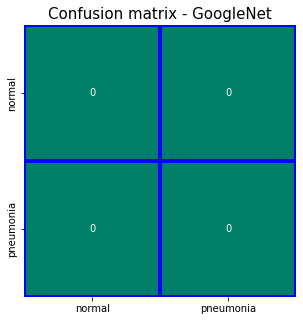

In [ ]:
from pytorch_lightning import callbacks

"""
data_module = PneumoniaDataModule()
total_length = len(data_module.test_dataloader()) + len(data_module.val_dataloader())+ len(data_module.train_dataloader())

print("1")
print(len(data_module.test_dataloader())/total_length)
print("2")
print(len(data_module.val_dataloader())/total_length)
print("3")
print(len(data_module.train_dataloader())/total_length)
print("end")
"""

torch.cuda.empty_cache()
AVAIL_GPUS = min(1, torch.cuda.device_count())
wandb_logger = WandbLogger(save_dir='wdb_log',name='densenet_model',project="DENSNET", log_model="all")
tb_logger = TensorBoardLogger(save_dir="tb_logs", name="densenet_model")

path1 = "/content/cnn_pneumonia_googlenet.pth"
model = PneumoniaClassifier(learning_rate=1e-5)
model.load_state_dict(torch.load(path1))

#trainer = pl.Trainer(gpus = AVAIL_GPUS, auto_lr_find=True, max_epochs = 11,logger=[wandb_logger,tb_logger], track_grad_norm='inf')
#trainer.test(model, data_module)
print(model.confusion_matrix.compute())

import seaborn as sns
fig = plt.figure(figsize=(5,5))
sns.heatmap(model.confusion_matrix.compute(), annot=True,cmap='summer',square=True, xticklabels=['normal','pneumonia'],yticklabels=['normal','pneumonia'],fmt="d", cbar=False,linewidths=3, linecolor='b')
plt.title('Confusion matrix - GoogleNet',fontsize=15)

####################################################
path2 = "/content/cnn_pneumonia_resnet.pth"

model2.load_state_dict(torch.load(path2))

trainer2.test(model2, data_module2)
print(model2.confusion_matrix.compute())

import seaborn as sns
fig = plt.figure(figsize=(5,5))
sns.heatmap(model2.confusion_matrix.compute(), annot=True,cmap='summer',square=True, xticklabels=['normal','pneumonia'],yticklabels=['normal','pneumonia'],fmt="d", cbar=False,linewidths=3, linecolor='b')
plt.title('Confusion matrix - ResNet',fontsize=15)

############################################################
path3 = "/content/cnn_pneumonia_densnet.pth"

model3.load_state_dict(torch.load(path3))
trainer3.test(model3, data_module3)
print(model3.confusion_matrix.compute())

#

In [ ]:
#sns.piechart

In [ ]:
%%wandb
%wandb Wiiggee1/GOOGLENET

In [ ]:
#model_resnet = PneumoniaClassifier.load_from_checkpoint('/content/drive/MyDrive/saved_models/ResNet.95.ckpt')

#model_densenet = PneumoniaClassifier.load_from_checkpoint('/content/drive/MyDrive/saved_models/densenet.95.ckpt')